In [ ]:
import stata_setup
import pandas as pd
stata_setup.config("/Applications/STATA","se")

In [ ]:
%%stata

global data  "/Users/brunokomel/Documents/Pitt/Year 3/TA - Econ 3080/econ-3080-recitations"
global working  "/Users/brunokomel/Documents/Pitt/Year 3/TA - Econ 3080/econ-3080-recitations/Recitation 2 - DiD"

In [ ]:
%%stata

cd "${data}"

In [ ]:
%%stata

set scheme gg_tableau

# Card and Krueger


### Studied the effect of changes in minimum wages by comparing a treated state (New Jersey) and an untreated one (Pennsylvania)

https://davidcard.berkeley.edu/papers/njmin-aer.pdf

#### They find that the increase in minimum wage did not lead to a subsequent decrease in employment (DiD). But, what's the issue with saying that this effect is causal?

In [ ]:
%%stata -doutd df1

use "https://github.com/brunokomel/econ-3080-recitations/raw/main/Recitation%202%20-%20DiD/public.dta", clear

keep STATE EMPFT EMPPT EMPFT2 EMPPT2 NMGRS NMGRS2 SHEET

In [ ]:
%%stata

foreach var of varlist * {
di "`var'" _col(20) "`: var l `var''" _col(50)  "`: val l `var''"
}


In [ ]:
display(df1)

In [ ]:
%%stata -doutd df1

/* Calculate FTE employement */
gen FTE  = EMPFT  + 0.5 * EMPPT  + NMGRS
label var FTE  "FTE employment before"
gen FTE2 = EMPFT2 + 0.5 * EMPPT2 + NMGRS2
label var FTE2 "FTE employment after"

gen dif = FTE - FTE2

In [ ]:
display(df1)

In [ ]:
%%stata

tabstat FTE FTE2, by(STATE) stat(mean semean)

In [ ]:
%%stata -doutd df1

** Editing the data so we can match the paper
expand 2 
** This creates a dublciate of each observation and it appends it to the bottom of the dataset


In [ ]:
display(df1)

In [ ]:
%%stata

gen id = _n 

## Since the data is compiled with one observation per "sheet" or store, 
## I want to separate them between prior and post treatment

In [ ]:
%%stata -doutd df1

gen after = 1 if id > _N/2 
## creating the "after" treatment indicator
replace after = 0 if id <= _N/2


In [ ]:
display(df1)

In [ ]:
%%stata

tab STATE, gen(state) 
## this will create indicator variables for each state

In [ ]:
%%stata

rename state2 nj 
## naming one variable after New Jersey

In [ ]:
%%stata -doutd df1

gen njafter = after*nj 
## creating an interaction term

In [ ]:
display(df1)

In [ ]:
%%stata


gen fte = FTE 
#I don't like capital letters and I want this new "fte" variable to disagreggate
#the FTE and FTE2 variables into different observations



In [ ]:
%%stata

replace fte = FTE2 if after ==1 

## Replicating Table 3, Card and Krueger (1994)

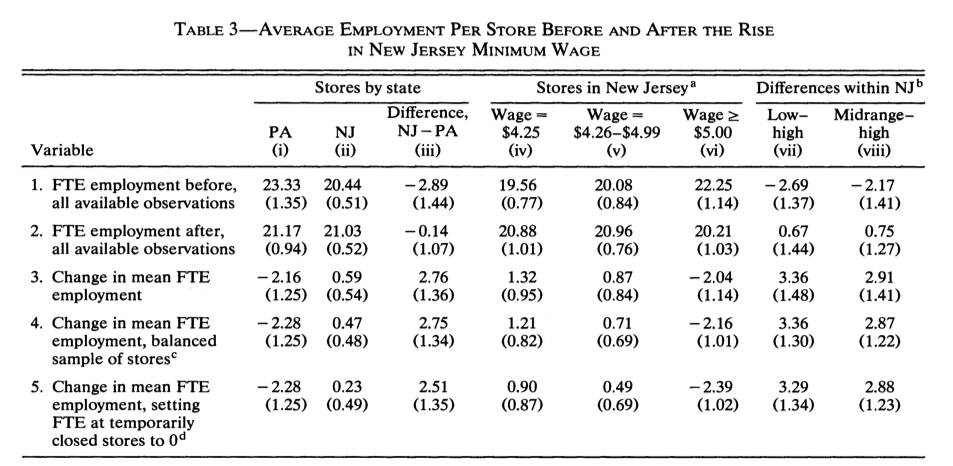

In [ ]:
%%stata

## Now we can do Diff-in-Diff analyses:

reg fte nj after njafter, robust
## The traditional specification

In [ ]:
%%stata  
sum fte if after == 0 
global pa_mean_before = `r(mean)'

di $pa_mean_before

In [ ]:
%%stata

bys nj: sum fte if after ==0

qui sum fte if after == 0 & nj == 0
global pa_mean_before = `r(mean)'

qui sum fte if after == 0 & nj == 1
global nj_mean_before = `r(mean)'
    
bys nj: sum fte if after == 1
    
qui sum fte if after == 1 & nj == 0
global pa_mean_after = `r(mean)'

qui sum fte if after == 1 & nj == 1
global nj_mean_after = `r(mean)' 

In [ ]:
%%stata 
di $nj_mean_before - $pa_mean_before

global d1 = $nj_mean_before - $pa_mean_before

di $nj_mean_after - $pa_mean_after

global d2 = $nj_mean_after - $pa_mean_after

di $d2 - $d1

In [ ]:
%%stata

reg fte njafter nj after, cluster(SHEET) 
## Clustering Standard Errors by store

In [ ]:
%%stata

reg fte nj##after, cluster(SHEET)

In [ ]:
%%stata

reg dif nj after nj#after, robust 
// An alternative way to run this regression
// here, we're just running the regression on the difference (dif)

In [ ]:
%%stata

reg dif nj after njafter, robust 
##A little cleaner way to do the same thing as above

In [ ]:
%%stata

// ssc install diff
diff fte, t(nj) p(after)

// Look at this nice command. t(.) indicates the treatment variable,
// and p(.) indicates the period variable (should = 1 for the post period)



In [ ]:
%%stata -doutd df2

preserve 
qui reg fte nj after njafter, robust

collapse (mean) fte, by(nj after)

restore


In [ ]:
display(df2)

In [ ]:
%%stata

twoway (connected fte after if nj ==1, color(blue)) (connected fte after if nj ==0, color(red)), xline(0.5) ///
legend(label(1 NJ - Treatment) label(2 PA - Control)) 
save working_data_did, replace

In [ ]:
%%stata
use "https://github.com/brunokomel/econ-3080-recitations/raw/main/Recitation%202%20-%20DiD/working_data.dta", clear

quietly reg fte nj after njafter, robust 
##I'm just running this because I want to store one of the coefficients
gen fte_did = fte + _b[nj] 
##Storing the coefficients + the constant so we can observe the 'counterfactual


In [ ]:
%%stata

## preserve

## reg fte nj after njafter, robust

collapse (mean) fte fte_did, by(nj after)

twoway (connected fte after if nj ==1, color(blue)) (connected fte after if nj ==0, color(red)) ///
(connected fte_did after if nj ==0, color(red) lpattern(dash)) , ///
xline(0.5)   legend(label(1 NJ - Treatment) label(2 PA - Control) label(3 Counterfactual) ) 

##restore


# Exercise

In [ ]:
%%stata -doutd df2

use "https://github.com/brunokomel/econ-3080-recitations/raw/main/Recitation%202%20-%20DiD/panel101.dta", clear 

//reference: slides by Torres-Reyna @ https://www.princeton.edu/~otorres/DID101.pdf


In [ ]:
display(df2)

### 1. Create a "post" variable which is equal to 1 if the observation takes place on or after 1994 (careful with missing values)

### 2. Create a treated variable which is equal to 1 for countries 4, 5, 6, and 7.

### 3. Create a variable for the interaction term

### 4. Estimate the DiD coefficient using the 'diff' command

### 5. Estimate the DiD coefficient using the regression command

### 6. Repeat part 5, but this time use the '##' option.

### 7. Plot the DiD coefficeint as we did earlier, using the twoway command. (Be sure to usee preserve & restore)

In [ ]:
%%stata

tab year //from 1990 to 1999
tab country, nolabel //7 countries

### 1. Create a "post" variable which is equal to 1 if the observation takes place on or after 1994 (careful with missing values)

In [ ]:
%%stata
* 1. 
gen time = (year>=1994) & !missing(year) 
//generating before and after period, equivalent to a time fixed effect 

### 2. Create a treated variable which is equal to 1 for countries 4, 5, 6, and 7.

In [ ]:
%%stata

*2. 

gen treated = (country > 4) & !missing(country) 

// generating treatment units and non-treatment units, equivalent to a group fixed effect 


### 3. Create a variable for the interaction term

In [ ]:
%%stata

*3.

gen did = time*treated 

// did = 1 if country > 4 and year >= 1994

### 4. Estimate the DiD coefficient using the 'diff' command

In [ ]:
%%stata

*4.
diff y, t(treated) p(time) 


### 5. Estimate the DiD coefficient using the regression command

In [ ]:
%%stata

*5. 

reg y time treated did


### 6. Repeat part 5, but this time use the '##' option.

In [ ]:
%%stata

*6. 

reg y time##treated



### 7. Plot the DiD coefficeint as we did earlier, using the twoway command. (Be sure to usee preserve & restore)

In [ ]:
%%stata

*7. 


reg y time treated did
gen y_did = y + _b[treated]


In [ ]:
%%stata

collapse (mean) y y_did , by(treated time)

twoway (connected y time if treated ==1, color(blue)) (connected y time if treated ==0, color(red)) ///
(connected y_did time if treated ==0, color(red) lpattern(dash))  , ///
xline(0.5) legend(label(1 Treated) label(2  Control) label(3 Counterfactual))
